# 04. 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS)



1. 네거티브 샘플링(Negative Sampling)
- Word2Vec이 학습 과정에서 전체가 아닌 '일부' 단어 집합에만 집중할 수 있도록 하는 방법 
- 후에 이진 분류 문제(주변 단어: positive, 랜덤 샘플링 단어: negative)로 변환 -> 연산량에서 효율적 


2. 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS) 
- Skip-Gram: 중심 단어로부터 주변 단어를 예측하는 모델 
- 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지의 확률을 예측함 
- Skip-Gram에서 SGNS 데이터셋으로 변환하는 과정 
    - 중심 단어와 주변 단어를 입력 1, 입력2로 두고, 공통으로 레이블 1로 수정
    - 랜덤 단어는 입력 2로 두고 레이블 0으로 둠 
    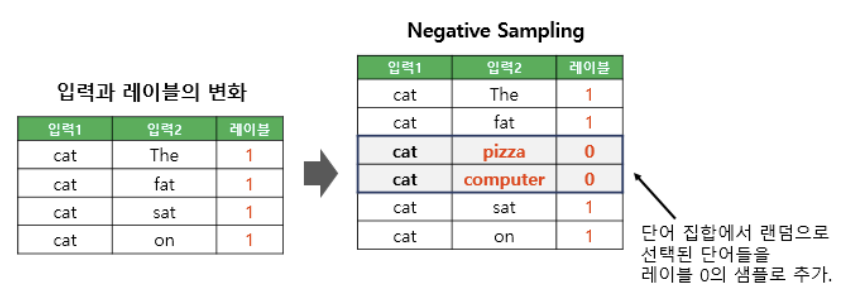
    - 입력 1인 중심 단어, 입력 2인 주변 단어의 테이블 룩업을 위한 임베딩 테이블을 각각 준비함 
    - 임베딩 벡터로 변환함 
    - 중심 단어와 주변 단어의 내적값을 모델의 예측값으로 하고, 레이블과의 오차값을 역전파하여 임베딩 벡터값을 업데이트함 
    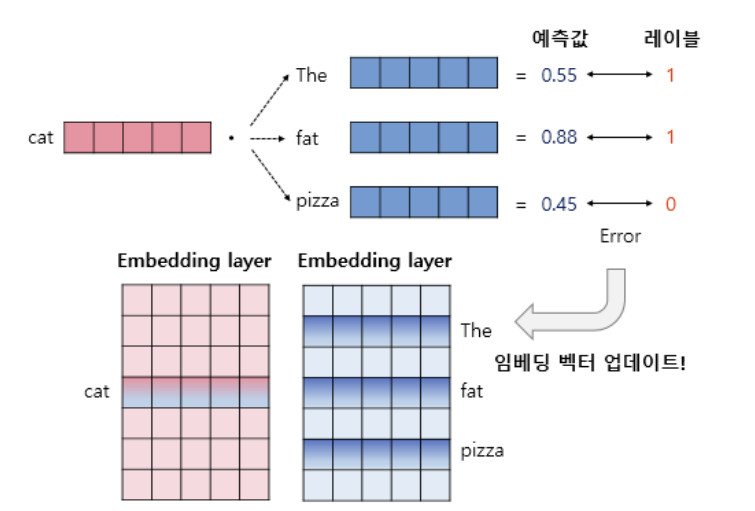

3. 20 뉴스그룹 데이터 전처리하기 

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

print('총 샘플 수:', len(documents))

총 샘플 수: 11314


In [3]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3 이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-3-10af84462ca0>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [4]:
news_df.isnull().values.any()

False

In [5]:
news_df.replace("", float("NaN"), inplace = True)
news_df.isnull().values.any()

True

In [6]:
news_df.dropna(inplace=True)
print('총 샘플 수:',len(news_df))

총 샘플 수: 10995


불용어 제거 

In [ ]:
import nltk
nltk.download()

In [ ]:
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [ ]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc)
if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis = 0)

print('총 샘플의 수:', len(tokenized_doc))

In [ ]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)
word2idx = tokenizer.word_index
idx2word = {value: key for key, value in word2idx.itmes()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
print(encoded[:2])

In [ ]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기:', vocab_size)

4. 네거티브 샘플링을 통한 데이터셋 구성하기 

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size = vocab_size, window_size = 10) 
for sample in encoded[:10]]

In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
  print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

In [ ]:
print('전체 샘플 수:', len(skip_grams))

In [ ]:
print(len(pairs))
print(len(labels))

In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size = vocab_size, window_size = 10) 
for sample in encoded]

5. Skip-Gram with Negative Sampling(SGNS) 구현하기 

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape(1, ), dtype ='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype = 'int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [ ]:
dot_product = Dot(axes = 2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape = (1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs = output)
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
plot_model(model, to_file = 'model3.png', show_shapes = True, show_layer_names = True, rankdir ='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

6. 결과 확인하기 

In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['soldiers'])

In [ ]:
w2v.most_similar(positive=['doctor'])

In [ ]:
w2v.most_similar(positive=['police'])

In [ ]:
w2v.most_similar(positive=['knife'])

In [ ]:
w2v.most_similar(positive=['engine'])